# BigData Project

## Installation

On this project, the first step was to install Hadoop and Spark in an Ubuntu environment.

### Hadoop

I followed all the commands necessary, but, due to the way my Ubuntu root path was created, I had added also the sumpplementary lines:
```
export HDFS_NAMENODE_USER="root"
export HDFS_DATANODE_USER="root"
export HDFS_SECONDARYNAMENODE_USER="root"
export YARN_RESOURCEMANAGER_USER="root"
export YARN_NODEMANAGER_USER="root"
```
Then, I could check if the installation was successful by seeing if the services were launched and if the hdfs commands worked.

![Hadoop installation](./ReportImages/HadoopInstall.png)

### Spark

After the typing all the necessary commands, spark services were also running correctly.

![Spark installation](./ReportImages/SparkInstall.png)

Accordingly, the conda and pyspark installations occurred also with no problems.

![Pyspark](./ReportImages/Pyspark.png)

However, even with the local installation in Ubuntu, it was simpler to use a jupyter notebook image at a docker container, including pyspark and all the installations necessary. Thus, the Spark part of the project, was developed using Docker.

### Dask

In order to use the Dask framework, a special environment *dask_env* was built during our BigData classes. It runs locally on Windows and it was used for the Dask part of the project.

## Exercise 1 -  Spark ML : Iris classification

In this exercise, we are going to compare 3 tree based algorithms for machine learning classification of flower species using Spark: decision trees, gradient boosted trees, and random forests. For the gradient boosted trees, as spark algorithm only supported binary classification and the problem had 3 labels, it was manually used the 1xall strategy, converting the labels for each case and creating the 3 different models, for then find their errors and compute the total accuracy. Before applying the algorithms, a Spark pipeline prepare the data to be used.

In [4]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import SQLContext
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark import SparkFiles
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

"""----------------------------------------------------------------------------
CREATE SPARK CONTEXT
CREATE SQL CONTEXT
----------------------------------------------------------------------------"""
#sc =SparkContext()
sc = SparkContext.getOrCreate();
sqlContext = SQLContext(sc)

In [7]:

"""----------------------------------------------------------------------------
LOAD IRIS DATA
----------------------------------------------------------------------------"""
data_dir="data_project/"
file = os.path.join(data_dir,"iris.csv")
panda_df = pd.read_csv(file)

iris_df=sqlContext.createDataFrame(panda_df)
iris_df.printSchema()

#Add a numeric indexer for the label/target column
from pyspark.ml.feature import StringIndexer
stringIndexer = StringIndexer(inputCol="variety", outputCol="ind_variety")
si_model = stringIndexer.fit(iris_df)
irisNormDf = si_model.transform(iris_df)
irisNormDf.printSchema()
irisNormDf.select("variety","ind_variety").distinct().collect()
#irisNormDf.cache()

"""--------------------------------------------------------------------------
Perform Data Analytics
-------------------------------------------------------------------------"""

#See standard parameters
#irisNormDf.describe().show()


"""--------------------------------------------------------------------------
Prepare data for ML
-------------------------------------------------------------------------"""

#Transform to a Data Frame for input to Machine Learing
#Drop columns that are not required (low correlation)

from pyspark.ml.linalg import Vectors
def transformToLabeledPoint(row) :
    lp = ( row["variety"], row["ind_variety"], \
                Vectors.dense([row["sepal_length"],\
                        row["sepal_width"], \
                        row["petal_length"], \
                        row["petal_width"]]))
    return lp

irisLp = irisNormDf.rdd.map(transformToLabeledPoint)
irisLpDf = sqlContext.createDataFrame(irisLp,["species","label", "features"])
#irisLpDf.select("species","label","features").show(50)
#irisLpDf.cache()

"""--------------------------------------------------------------------------
Perform Machine Learning
-------------------------------------------------------------------------"""
seed = 1
#Split into training and testing data
(trainingData, testData) = irisLpDf.randomSplit([0.9, 0.1], seed=seed)
# trainingData.count()
# testData.count()
# testData.collect()

#Create the model
dtClassifer = DecisionTreeClassifier(maxDepth=4, labelCol="label",\
                featuresCol="features")
dtModel = dtClassifer.fit(trainingData)

rfClassifier = RandomForestClassifier(numTrees=3, maxDepth=4, labelCol="label",\
                featuresCol="features")
rfModel = rfClassifier.fit(trainingData)

#print(dtModel.numNodes)
#print(dtModel.depth)

#Predict on the test data
predictionsDT = dtModel.transform(testData)
#predictions.select("prediction","species","label").collect()

#Evaluate accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", \
                    labelCol="label",metricName="accuracy")
print( "Decision Tree accuracy:", evaluator.evaluate(predictionsDT)) 

predictionsRF = rfModel.transform(testData)
print( "Random forest accuracy:", evaluator.evaluate(predictionsRF)) 

#Draw a confusion matrix
#predictions.groupBy("label","prediction").count().show()

accurate_predictions = []
for label in range(3):
    labels = [0, 1, 2]
    del labels[label]
    convert = {label : 0, labels[0]: 1, labels[1]: 1}
    convertedDF = irisLpDf.rdd.map(lambda x: (x.features, convert[x.label])).toDF(["features", "label"])
    (trainingData, testData) = convertedDF.randomSplit([0.9, 0.1], seed=seed)
    gbModel = GBTClassifier(maxIter=5, maxDepth=4, labelCol="label",\
                featuresCol="features")
    gbModel = gbModel.fit(trainingData)
    predictions = gbModel.transform(testData)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", \
                    labelCol="label",metricName="accuracy")
    accurate_predictions.append(evaluator.evaluate(predictions) * testData.count())
print("Boosted trees accuracy:", sum(accurate_predictions)/3/testData.count())

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- variety: string (nullable = true)

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- variety: string (nullable = true)
 |-- ind_variety: double (nullable = false)



Decision Tree accuracy: 0.875
Random forest accuracy: 0.9375


Boosted trees accuracy: 0.9375


As we can see, the performance of the random forest model is similar to the boosted trees one, but both are superior in comparison to the Decision tree model. Of course, the methodology used for computing the accuracy only once in the test set is not the best one, seen that this test set can vary a lot depending of how the original data set was split at the beginning, which is controlled by the *seed*. Therefore, changing the *seed* can change a lot the accuracy of the models, especially for such a small data set. To resolve this problem, we could apply a k-fold cross-validation.

## Exercise 2 - Spark : parallelisation of the image processing algorithm « MedianFilter »

In this exercise, we are applying a median filter to a noisy image. In pyspark, this can be parallelized by creating different processes with *SparkContext.parallelize()*. Each one of those processes receives the whole image, but computes the values filter values only in a subset of the image, a new buffer. All local images are retrieved from each process and concatenated in order to achieve the final filtered image, which we can see right after the code. There's also the option to convert the image to a grey scale, in order to simplify the computation.

In [9]:
#!pip install imageio
import pyspark
from pyspark import SparkContext
import imageio
import os
import numpy as np

# Transform the image in grey before applying the filter
grey_bool = False

def readImg(path):
    img = imageio.imread(path)
    im = np.array(img,dtype='uint8')
    return im

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def writeImg(path,buf):
    imageio.imwrite(path,buf)

def part_median_filter(local_data):
    part_id = local_data[0]
    first   = local_data[1]
    end     = local_data[2]
    buf     = local_data[3]
    nx=buf.shape[0]
    ny=buf.shape[1]
    
    ########################################
    #
    # CREATE NEW BUF WITH MEDIAN FILTER SOLUTION
    #
    r = int(end-first)
    new_buf = np.zeros([r, ny],dtype='uint8') if grey_bool else np.zeros([r, ny, 3],dtype='uint8')

    ##########################################
    #
    # TODO COMPUTE MEDIAN FILTER
    #
    #print(part_id, first, end, buf.shape, nx, ny)
    for i in range(int(first), int(end)):
        for j in range(ny):
            median_list = []
            
            if i != 0 and j != 0:
                median_list.append(buf[i-1,j-1])
            if i != 0:
                median_list.append(buf[i-1,j])
            if i != 0 and j != ny-1:
                median_list.append(buf[i-1,j+1])
            if j != 0:
                median_list.append(buf[i,j-1])
                
            median_list.append(buf[i,j])
            
            if j != ny-1:
                median_list.append(buf[i,j+1])
            if i != end-1 and j != 0:
                median_list.append(buf[i+1,j-1])
            if i != end-1:
                median_list.append(buf[i+1,j])
            if i != end-1 and j != ny-1:
                median_list.append(buf[i+1,j+1])
            
            if grey_bool:
                new_buf[int(i-first), j] = np.median(median_list)
            else:
                new_buf[int(i-first), j, :] = np.median(median_list, axis=0)
    
    
    ##########################################
    #
    # RETURN LOCAL IMAGE PART
    #
    return part_id,new_buf

def main(partitions,  outputs=True):
    data_dir = "data_project/"
    file = os.path.join(data_dir,'lena_noisy.jpg')
    img_buf=readImg(file)
    if grey_bool:
        img_buf=rgb2gray(img_buf)
    if outputs:
        print('SHAPE',img_buf.shape)
        #print('IMG\n',img_buf)
    nx=img_buf.shape[0]
    ny=img_buf.shape[1]
    
    ###########################################################################
    #
    # SPLT IMAGES IN NB_PARTITIONS PARTS
    nb_partitions = partitions
    if outputs:
        print("NB PARTITIONS : ",nb_partitions)
    data=[]
    begin=0
    block_size=nx/nb_partitions
    for ip in range(nb_partitions):
        end=min(begin+block_size,nx)
        data.append([ip,begin,end,img_buf])
        begin=end
    
    
    ###########################################################################
    #
    # CREATE SPARKCONTEXT
    sc =SparkContext.getOrCreate();
    data_rdd = sc.parallelize(data,nb_partitions)
    
    ###########################################################################
    #
    # PARALLEL MEDIAN FILTER COMPUTATION
    result_rdd = data_rdd.map(part_median_filter)
    result_data = result_rdd.collect()

#     new_img_buf=np.zeros([nx,ny],dtype='uint8')
    ###########################################################################
    #
    # COMPUTE NEW IMAGE RESULTS FROM RESULT RDD
    # TODO
    new_img_buf = np.concatenate([part[1] for part in result_data])
    
    if outputs:
        print('CREATE NEW PICTURE FILE')
    filter_file = os.path.join(data_dir,'lena_filter.jpg')
    writeImg(filter_file,new_img_buf)

if __name__ == '__main__':
    main(8)


SHAPE (128, 128, 3)
NB PARTITIONS :  8
CREATE NEW PICTURE FILE


Lena noizy          |  Lena filtered Spark
:-------------------------:|:-------------------------:
![Lena noizy](./data_project/lena_noisy.jpg) | ![Lena filtered](./data_project/lena_filter_spark.jpg)

---
Speedup curves for 1, 2, 4 and 8 processes.

For each number of processes, 5 runs were computed and the time was averaged to have a more precise measurement.

In [11]:
from time import perf_counter
times = {1: [], 2:[], 4:[], 8:[]}
for _ in range(5):
    for partitions in times.keys():
        t1 = perf_counter()
        main(partitions, outputs=False)
        t2 = perf_counter()
        perf = t2-t1
        times[partitions].append(perf)
        
n_times_partition = [np.mean(l) for l in times.values()]

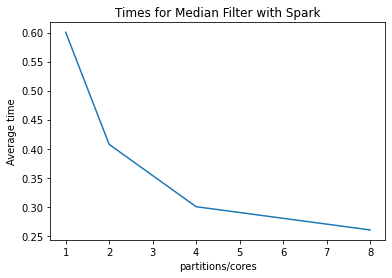

In [18]:
from matplotlib import pyplot as plt
plt.plot(times.keys(), n_times_partition)
plt.xlabel('partitions/cores')
plt.ylabel('Average time')
plt.title('Times for Median Filter with Spark')
plt.show()

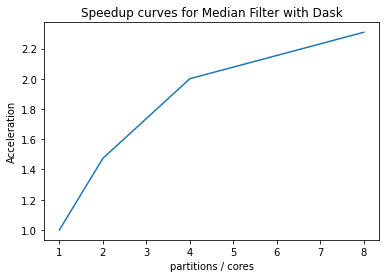

In [19]:
acc_partition =  n_times_partition[0] / n_times_partition
plt.plot(times.keys(), acc_partition)
plt.xlabel('partitions / cores')
plt.ylabel('Acceleration')
plt.title('Speedup curves for Median Filter with Dask')
plt.show()

As we can see from the curves above, by increasing the number of cores, we are able to compute faster the median filter, even if the acceleration steepness decreases.

## Exercise 3 (Extra)-  Dask ML : flower segmentation

This exercise was not demanded in this year's project, but I retrieved it from the last year's project

In [22]:
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da
import warnings
warnings.filterwarnings('ignore')

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
filename_pattern = os.path.join('flower_images', '*.png')
tiled_flower_images = dask_image.imread.imread(filename_pattern)

dask.array<concatenate, shape=(210, 128, 128, 4), dtype=float32, chunksize=(1, 128, 128, 4), chunktype=numpy.ndarray>


In [57]:
def grayscale(rgb):
    result = ((rgb[..., 0] * 0.2125) +
              (rgb[..., 1] * 0.7154) +
              (rgb[..., 2] * 0.0721))
    return result

Num labels: 11


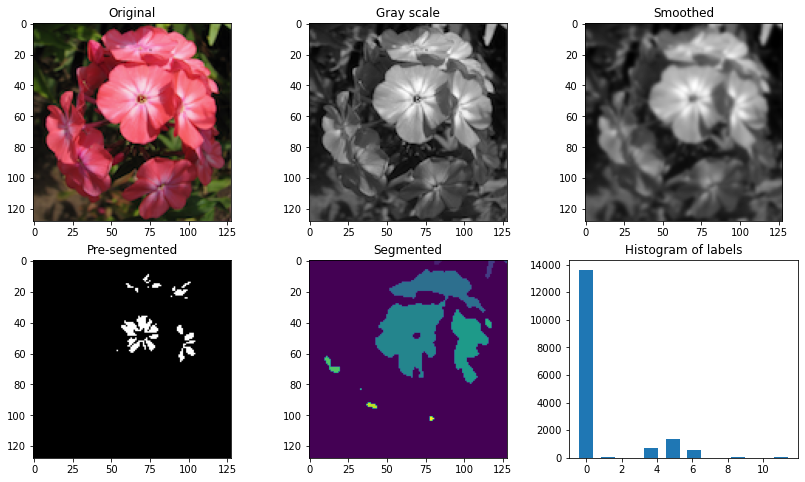

In [176]:
gray_flower_images = grayscale(tiled_flower_images)

def pipeline(img_index, images, threshold = 0.75):
    smoothed_image = dask_image.ndfilters.gaussian_filter(images[img_index], sigma=[1, 1])
    threshold_value = threshold * da.max(smoothed_image).compute()
    threshold_flower_image = smoothed_image > threshold_value
    label_image, num_labels = dask_image.ndmeasure.label(threshold_flower_image)
    print("Num labels:", int(num_labels))
    nbins = 10
    da_histogram = dask_image.ndmeasure.histogram(label_image.compute(), 0, int(num_labels), nbins)
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))
    ax[0,0].imshow(tiled_flower_images[img_index])
    ax[0,0].set_title('Original')
    ax[0,1].imshow(images[img_index], cmap='gray')
    ax[0,1].set_title('Gray scale')
    ax[0,2].imshow(smoothed_image, cmap='gray')
    ax[0,2].set_title('Smoothed')
    ax[1,0].imshow(threshold_flower_images[img_index], cmap='gray')
    ax[1,0].set_title('Pre-segmented')
    ax[1,1].imshow(label_image, cmap='viridis')
    ax[1,1].set_title('Segmented')
    ax[1,2].bar(np.linspace(0, int(num_labels), nbins), da_histogram.compute())
    ax[1,2].set_title('Histogram of labels')
    
    plt.show()

pipeline(0, gray_flower_images, threshold=0.6)


## Exercise 4 -  Dask ML : Iris classification

In this exercise, we have the same objective as in exercise 1: to predict flower species using 3 tree based models and analyse its performance. However, instead of Spark, Dask is used for this task, profiting from the integration with other libraries such as Scikit-learn and XGBOOST. Before applying the algorithms, a Dask pipeline prepare the data to be used.

In [38]:
import dask.array as da
from dask import dataframe
import imageio
import os
import numpy as np
from dask_ml.xgboost import XGBClassifier
from dask.distributed import Client
import dask.dataframe as dd
from dask import compute
from dask_ml import preprocessing
from dask_ml.model_selection import train_test_split
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [39]:
data_dir="data_project/"
file = os.path.join(data_dir,"iris.csv")
client = Client(n_workers=4)

In [40]:
iris_df = dataframe.read_csv(file)

#Add a numeric indexer for the label/target column
#iris_df["variety"] = iris_df["variety"].replace({"Setosa":0, "Versicolor": 1, "Virginica":2})
le = preprocessing.LabelEncoder()
iris_df["variety"] = le.fit_transform(iris_df["variety"])
y = iris_df["variety"]
X = iris_df.drop("variety",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle=True, test_size=0.1)

In [43]:
cl = DecisionTreeClassifier(max_depth=4)
cl.fit(X_train, y_train)
y_pred = cl.predict(X_test)

cl2 = RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1)
cl3 = XGBClassifier(max_depth=4, n_estimators=100, n_jobs=-1)
with joblib.parallel_backend('dask'):
    cl2.fit(X_train, y_train)
    cl3.fit(X_train, y_train)
    
y_pred2 = cl2.predict(X_test)
y_pred3 = cl3.predict(X_test)

print("Decision tree: ", accuracy_score(y_pred, y_test))
print("Random forest: ", accuracy_score(y_pred2, y_test))
print("Boosted trees", accuracy_score(y_pred3.compute(), y_test))

Decision tree:  0.9375
Random forest:  0.9375
Boosted trees 0.9375


In [44]:
client.close()

In this case, no change can be seen in the performance of the models, different from what could be expected. In fact, the data set is very small, and the Sciki-learn Decision tree algorithm is already sufficiently powerful to make a good prediction in the test base. Therefore, adding more trees in a Random forest or Boosting trees models, is not sufficient to improve the performance - more data would be required.

## Exercise 5 -  Dask : parallelisation of the image processing algorithm « MedianFilter »

Here, the same parallelisation that was done with Spark to filter the noisy image, is done with Dask. The code, however, is a little simpler, because Dask tools take charge to divide the image and pass only the partitioned image as chunks to the median function. The partitions were made row wise, that is the local image had all the columns but only a part of the rows. As the median function uses adjacent pixels to compute the result, dask has to pass an extra row of pixels and overlap the results when concatenating the images. There's also the option to convert the image to a grey scale, in order to simplify the computation.

In [36]:
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
import dask.array as da
import imageio
import os
import numpy as np
import warnings
from dask.distributed import Client
warnings.filterwarnings('ignore')

grey_bool = False

def readImg(path, partitions, outputs=True):
    img = imageio.imread(path)
    im = np.array(img,dtype='uint8')
    nb_partitions = partitions
    if outputs:
        print("NB PARTITIONS : ",nb_partitions)
    
    # Divide the image in chunks, row wise
    chunk_size = [img.shape[1]//nb_partitions, img.shape[1], img.shape[2]]
    img = da.from_array(im, chunks=chunk_size)
    return img

def grayscale(rgb):
    result = ((rgb[..., 0] * 0.2125) +
              (rgb[..., 1] * 0.7154) +
              (rgb[..., 2] * 0.0721))
    return result

def writeImg(path,buf):
    imageio.imwrite(path,buf)

def part_median_filter(local_img):
    nx=local_img.shape[0]
    ny=local_img.shape[1]
    ##########################################
    #
    # TODO COMPUTE MEDIAN FILTER
    #
    for i in range(nx):
        for j in range(ny):
            median_list = []
            
            if i != 0 and j != 0:
                median_list.append(local_img[i-1,j-1])
            if i != 0:
                median_list.append(local_img[i-1,j])
            if i != 0 and j != ny-1:
                median_list.append(local_img[i-1,j+1])
            if j != 0:
                median_list.append(local_img[i,j-1])
                
            median_list.append(local_img[i,j])
            
            if j != ny-1:
                median_list.append(local_img[i,j+1])
            if i != nx-1 and j != 0:
                median_list.append(local_img[i+1,j-1])
            if i != nx-1:
                median_list.append(local_img[i+1,j])
            if i != nx-1 and j != ny-1:
                median_list.append(local_img[i+1,j+1])
            
            if grey_bool:
                local_img[i, j] = np.median(median_list)
            else:
                local_img[i, j, :] = np.median(median_list, axis=0) #median_list[len(median_list) // 2]

    ##########################################
    #
    # RETURN LOCAL IMAGE PART
    #
    return local_img

def main(partitions, outputs=True):
    data_dir = "data_project/"
    file = os.path.join(data_dir,'lena_noisy.jpg')
    img_buf=readImg(file, partitions, outputs=outputs)
    if grey_bool:
        img_buf=rgb2gray(img_buf)
    if outputs:
        print('SHAPE',img_buf.shape)
    
    ###########################################################################
    #
    # PARALLEL MEDIAN FILTER COMPUTATION
    new_img_buf = img_buf.map_overlap(part_median_filter, depth=(0, img_buf.shape[1])).compute()

    ###########################################################################
    
    if outputs:
        print('CREATE NEW PICTURE FILE')
        filter_file = os.path.join(data_dir,'lena_filter_dask.jpg')
        writeImg(filter_file,new_img_buf)

if __name__ == '__main__':
    client = Client(n_workers=8)
    main(8)
    client.close()

NB PARTITIONS :  8
SHAPE (128, 128, 3)
CREATE NEW PICTURE FILE


Lena noizy          |  Lena filtered Dask
:-------------------------:|:-------------------------:
![Lena noizy](./data_project/lena_noisy.jpg) | ![Lena filtered](./data_project/lena_filter_dask.jpg)

---
Speedup curves for 1, 2, 4 and 8 processes.

To calculate the acceleration, we have two options:
- Partition the image with the number of workers we pass, avoiding the overhead of unnecessary partitions.
- Keep a constant number of partitions (we will use 8) and only change the number of workers.

Each of those methods with different numbers of processes was run 5 times and the time was averaged to have a more precise measurement.

In [7]:
from time import perf_counter
times = {1: [], 2:[], 4:[], 8:[]}
for _ in range(5):
    for workers in times.keys():
        client = Client(n_workers=workers)
        t1 = perf_counter()
        main(workers, outputs=False)
        t2 = perf_counter()
        perf = t2-t1
        times[workers].append(perf)
        client.close()
        
n_times_partition = [np.mean(l) for l in times.values()]

In [8]:
from time import perf_counter
times = {1: [], 2:[], 4:[], 8:[]}
for _ in range(5):
    for workers in times.keys():
        client = Client(n_workers=workers)
        t1 = perf_counter()
        main(8, outputs=False)
        t2 = perf_counter()
        perf = t2-t1
        times[workers].append(perf)
        client.close()
        
n_times_const = [np.mean(l) for l in times.values()]

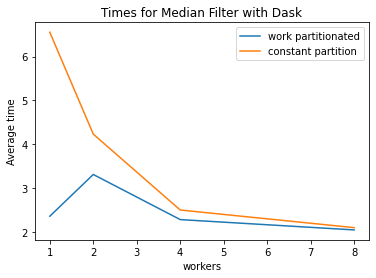

In [13]:
from matplotlib import pyplot as plt
plt.plot(times.keys(), n_times_partition, label='work partitionated')
plt.plot(times.keys(), n_times_const, label='constant partition')
plt.xlabel('workers')
plt.ylabel('Average time')
plt.legend()
plt.title('Times for Median Filter with Dask')
plt.show()

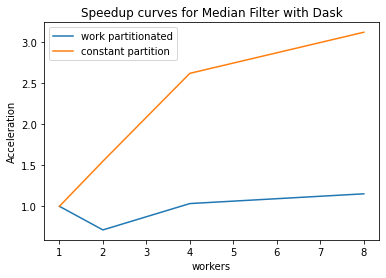

In [19]:
acc_partition =  n_times_partition[0] / n_times_partition
acc_const = n_times_const[0] / n_times_const
plt.plot(times.keys(), acc_partition, label='work partitionated')
plt.plot(times.keys(), acc_const, label='constant partition')
plt.xlabel('workers')
plt.ylabel('Acceleration')
plt.legend()
plt.title('Speedup curves for Median Filter with Dask')
plt.show()

As we can see, raising the number of workers used improves the acceleration. The partition and joining of the image, however, present an important overhead for one image, and therefore the use of only two workers for an image divided by two, is not worth it. Nevertheless, For 4 and 8 workers, it becomes relevant.